In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.models import model_from_json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
import math
import time

Using TensorFlow backend.


In [2]:
np.random.seed(1234) #set a randomseed so that the results can be repeated.

In [3]:
#let's first load the training data and understand the training data for both input and output.
# the data file can be downloaded from kaggle website: https://www.kaggle.com/c/digit-recognizer/data
training_data = pd.read_csv('MNISTI_train.csv')
training_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
# separate training data input and output.
X_train = training_data.drop(['label'], axis=1)
Y_train = training_data['label']
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
Y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [8]:
# take a look at the output statistics
Y_train.describe()

count    42000.000000
mean         4.456643
std          2.887730
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: label, dtype: float64

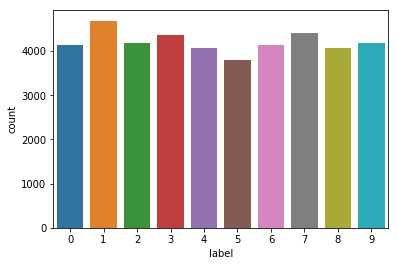

In [9]:
%matplotlib inline
g=sns.countplot(Y_train)

In [10]:
# Since keras model is dealing with numpy array, let's convert dataframe into numpy array. note that it has been change into float32. 
# This is mainly for speeding up training on GPU. Meanwhile, the resolution is more than enough:-). 
X_train_val = X_train.values.astype('float32')
Y_train_val = Y_train.values.astype('float32')

In [11]:
X_train_val.shape
Y_train_val.shape

(42000,)

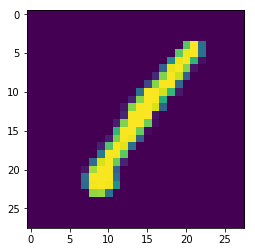

In [12]:
#since this is image, let's take a look at the input image first.
# we have 784 pixel, thus 784=28x28. only one channel.
X_display = X_train_val[0].reshape(28,28)
plt.imshow(X_display)

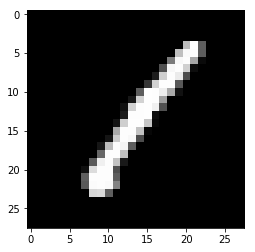

In [13]:
#the above image is in color. If we want to display it in gray.
plt.imshow(X_display, cmap='gray')

In [14]:
#define a CNN model
def cnn_model(input_shape, output_dim):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5,5), padding='same', strides=(2,2),
                    activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(32,kernel_size=(5,5), padding='same', activation='relu', strides=(2,2)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

In [15]:
#first we need to reshape the input to the input shape required by CNN model.
# as recall, the X_train_val is with shape of (42000, 784). It needs to be changed into (42000, 28, 28, 1), basically (# of samples, PixelX, PixelY, #of channels)
# in this case, # of channel is 1. 
# we have two way to reshape, we can either specify the number of samples (get it from X_train_val.shape[0]) or using reshape(-1, 28, 28,1)
# also, note that we do not split the training into training and validation manually. Instead we will use the validation_split option in kears.model.fit argument.
Pixel = int(math.sqrt(X_train_val.shape[1])) #instead of using 28, we get 28 from the intput shape to avoid hard code number.
X_train_val = X_train_val.reshape(-1, Pixel, Pixel, 1)
input_shape = (Pixel, Pixel,1) # the input shape of CNN.

In [16]:
#double check the shape
X_train_val.shape

(42000, 28, 28, 1)

In [17]:
# now let's process the labeled output. For a multiclass classification, we will need to change into one-hot vector and also loss function is
# categorial_crossentropy. For multilabel classification, the loss function is binary_crossentropy. 
# if the output is not numbers from 0 to 9, we generally need to convert it into numbers. and then do one-hot transform.
encoder = LabelEncoder() 
encoder.fit(Y_train_val)
encoder_class_filename ='MNIST_encoder_class.npy'
np.save(encoder_class_filename, encoder.classes_) # this is to save the encoder class. It is useful when we saved the model and then use the model on separate testing data.
encoded_y_train = encoder.transform(Y_train_val)
# the above four steps are not needed in this case as the output is from 0 to 9.
dummy_y_train = np_utils.to_categorical(encoded_y_train)
output_dim = dummy_y_train.shape[1]

In [18]:
output_dim

10

In [19]:
model = cnn_model(input_shape, output_dim)
num_parameter = model.count_params() # this is to count how many parameter in this model.
print(model.summary()) # this one gives the layout of the model. very useful!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
__________

In [20]:
log_filename = 'MNIST_training_log.csv'
model_filename = 'MNIST_model_filename.h5'
model_weight_filename = 'MNIST_model_weight_filename.json'
tic = time.clock()
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=2, mode='auto')
csv_logger = CSVLogger(log_filename, append=False, separator=',')
checkpoint = ModelCheckpoint(model_weight_filename, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [early_stop, csv_logger, checkpoint]
print("Training start")
model.fit(X_train_val, dummy_y_train, epochs=200, batch_size=512, validation_split=0.1, validation_data=None, callbacks=callbacks_list, verbose=2, shuffle=True)
toc = time.clock()
print("time took % seconds to train the model" %(toc-tic))
print("Saved the best model weights into disk: ", model_weight_filename)
# save the model itself
model_json = model.to_json()
with open(model_filename, "w") as json_file:
    json_file.write(model_json)
print("saved model to disk in file: ", model_filename)
print("saved training log to disk in file: ", log_filename)

Training start
Train on 37800 samples, validate on 4200 samples
Epoch 1/200
 - 13s - loss: 3.3855 - acc: 0.2595 - val_loss: 1.4590 - val_acc: 0.5219
Epoch 2/200
 - 12s - loss: 1.0322 - acc: 0.6561 - val_loss: 0.3994 - val_acc: 0.8921
Epoch 3/200
 - 12s - loss: 0.4583 - acc: 0.8510 - val_loss: 0.2274 - val_acc: 0.9312
Epoch 4/200
 - 12s - loss: 0.2940 - acc: 0.9070 - val_loss: 0.1676 - val_acc: 0.9500
Epoch 5/200
 - 12s - loss: 0.2350 - acc: 0.9255 - val_loss: 0.1459 - val_acc: 0.9581
Epoch 6/200
 - 12s - loss: 0.1884 - acc: 0.9404 - val_loss: 0.1366 - val_acc: 0.9586
Epoch 7/200
 - 12s - loss: 0.1606 - acc: 0.9505 - val_loss: 0.1127 - val_acc: 0.9657
Epoch 8/200
 - 12s - loss: 0.1413 - acc: 0.9558 - val_loss: 0.1079 - val_acc: 0.9681
Epoch 9/200
 - 13s - loss: 0.1218 - acc: 0.9627 - val_loss: 0.1031 - val_acc: 0.9700
Epoch 10/200
 - 12s - loss: 0.1101 - acc: 0.9660 - val_loss: 0.0960 - val_acc: 0.9721
Epoch 11/200
 - 12s - loss: 0.0991 - acc: 0.9697 - val_loss: 0.0853 - val_acc: 0.9738

In [22]:
# Since the above results without regularization shows training accuracy is higher than the validation accuracy(0.9999 vs. 0.9786), this is overfitting. Add dropout for regularization

In [24]:
# In the following, we will evaluate the model performance using testing data.
# let's first load the testing data.
test_data = pd.read_csv('MNIST_test.csv')
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [29]:
# there are 28000 samples to be tested. 
#preprocessing the test data into the format matching to the input of CNN model.
test_data_val = test_data.values.astype('float32')
PixelNum = int(math.sqrt(test_data_val.shape[1]))
test_data_val = test_data_val.reshape(-1, PixelNum, PixelNum, 1)
test_data_val.shape

(28000, 28, 28, 1)

In [30]:
 print("\nLoading saved model")
 model_filename = 'MNIST_model_filename.h5'
 model_weight_filename = 'MNIST_model_weight_filename.json'
 # load json and create model
 json_file = open(model_filename, 'r')
 loaded_model_json = json_file.read()
 json_file.close()
 loaded_model = model_from_json(loaded_model_json)
# load weights into new model
 loaded_model.load_weights(model_weight_filename)
 print("Loaded model from disk")
 print(loaded_model.summary())


Loading saved model
Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (No

In [56]:
predicted_y_test = loaded_model.predict(test_data_val)
predicted_y_test_val = np.argmax(predicted_y_test, axis=1)
encoder_class_filename ='MNIST_encoder_class.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(encoder_class_filename)
predicted_y_labeled = encoder.inverse_transform(predicted_y_test_val)
predicted_y_labeled = predicted_y_labeled.astype('int') # Watch Out for the output format: it should be in integer instead of float 

In [57]:
results = pd.Series(predicted_y_labeled, name='Label')
final_submission = pd.concat([pd.Series(range(1, predicted_y_labeled.shape[0]+1), name='ImageId'), results], axis=1)
final_submission.to_csv('MNIST_submission.csv', index=False)

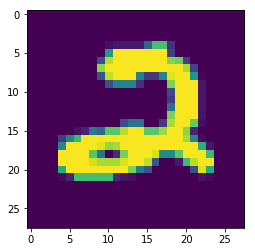

In [58]:
plt.imshow(test_data_val[0].reshape(28,28))